# Laboratory #10 : Vision Transformers

At the end of this laboratory, you would get familiarized with

*   Vision Transformers

**Remember this is a graded exercise.**

*   For every plot, make sure you provide appropriate titles, axis labels, legends, wherever applicable.
*   Create reusable functions where ever possible, so that the code could be reused at different places.
*   Add sufficient comments and explanations wherever necessary.
*   **Once you have the code completed, use GPU to train model faster.**

---

# Vision Transformers

Vision Transformers were introduced by Alexey Dosovitskiy et al. in the paper [An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale](https://arxiv.org/abs/2010.11929)

Read the ViT paper and answer the below descriptive questions.

*   What are the differences between CNN and Transformers?
*   What is Multi-head self-attention?
*   What is Inductive Bias?

**Solution**

*(Double-click or enter to edit)*

...

*   Explain the model architecture of ViT.

**Solution**

*(Double-click or enter to edit)*

...

# Introduction

We will implement the Vision Transformer (ViT) model for image classification and demonstrates it on the CIFAR-100 dataset.
The ViT model applies the Transformer architecture with self-attention to sequences of image patches, without using convolution layers.


## Setup
For this exercise, we require TensorFlow 2.4 or higher, as well as
[TensorFlow Addons](https://www.tensorflow.org/addons/overview)

In [ ]:
pip install -U tensorflow_addons

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa

/home/carles/Documents/UB/MAI/2324_CV_Practicals/venv/lib/python3.10/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


## Preparing the data

We will use the CIFAR-100 dataset available in tf.keras.datasets package.

In [3]:
num_classes = 100
input_shape = (32, 32, 3)

(x_train, y_train), (x_test, y_test) = keras.datasets.cifar100.load_data()

print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")

169001437/169001437 [==============================] - 126s 1us/step
x_train shape: (50000, 32, 32, 3) - y_train shape: (50000, 1)
x_test shape: (10000, 32, 32, 3) - y_test shape: (10000, 1)


## Configure the Hyper-parameters

In [13]:
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 256
num_epochs = 100
image_size = 72  # We'll resize input images to this size
patch_size = 6  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 8
mlp_head_units = [2048, 1024]  # Size of the dense layers of the final classifier

## Data Augmentation Pipeline

In [5]:
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size, image_size),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(
            height_factor=0.2, width_factor=0.2
        ),
    ],
    name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(x_train)

## Implement a Multi-layer Perceptron (MLP)

In [6]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

## Implementing Patch Creation Layer

In [7]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super().__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

### Visualizing the patches for a sample image

Image size: 72 X 72
Patch size: 6 X 6
Patches per image: 144
Elements per patch: 108


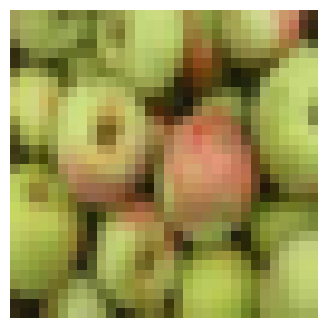

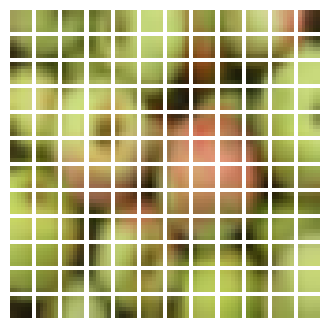

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(4, 4))
image = x_train[np.random.choice(range(x_train.shape[0]))]
plt.imshow(image.astype("uint8"))
plt.axis("off")

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)

patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))

plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")

## Patch Encoding Layer

*   What is the role of Patch Encoding Layer?

**Solution**

*(Double-click or enter to edit)*

...

In [9]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super().__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

*   What happens in the call function of the PatchEncoder class?

**Solution**

*(Double-click or enter to edit)*

...

## Building the ViT Model

*   We will use the MultiHeadAttention layer as self-attention for this implementation
*   PS: There are many changes to the original paper for ease of execution

In [10]:
def create_vit_classifier():
    inputs = layers.Input(shape=input_shape)
    # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches.
    patches = Patches(patch_size)(augmented)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(num_classes)(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model

*   Explain the execution of the ViT model. What is the sequence of operations?
*   What is skip connection? Why is it needed?

**Solution**

*(Double-click or enter to edit)*

...

*   What is self-attention?
*   What is the problem in using global self-attention?
*   What can be used instead of global self-attention?

**Solution**

*(Double-click or enter to edit)*

...

## Training the ViT Model

In [14]:
def run_experiment(model):
    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ],
    )

    checkpoint_filepath = "/tmp/checkpoint"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )

    history = model.fit(
        x=x_train,
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_split=0.1,
        callbacks=[checkpoint_callback],
    )

    model.load_weights(checkpoint_filepath)
    _, accuracy, top_5_accuracy = model.evaluate(x_test, y_test)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

    return history

In [15]:
vit_classifier = create_vit_classifier()
history = run_experiment(vit_classifier)

Epoch 1/5
176/176 [==============================] - 604s 3s/step - loss: 4.4546 - accuracy: 0.0493 - top-5-accuracy: 0.1691 - val_loss: 3.8880 - val_accuracy: 0.1078 - val_top-5-accuracy: 0.3164
Epoch 2/5
176/176 [==============================] - 617s 4s/step - loss: 3.9307 - accuracy: 0.0986 - top-5-accuracy: 0.2939 - val_loss: 3.5495 - val_accuracy: 0.1596 - val_top-5-accuracy: 0.4210
Epoch 3/5
176/176 [==============================] - 603s 3s/step - loss: 3.6879 - accuracy: 0.1337 - top-5-accuracy: 0.3702 - val_loss: 3.3531 - val_accuracy: 0.1968 - val_top-5-accuracy: 0.4634
Epoch 4/5
176/176 [==============================] - 607s 3s/step - loss: 3.5087 - accuracy: 0.1630 - top-5-accuracy: 0.4213 - val_loss: 3.1982 - val_accuracy: 0.2338 - val_top-5-accuracy: 0.5052
Epoch 5/5
313/313 [==============================] - 43s 138ms/step - loss: 3.0218 - accuracy: 0.2555 - top-5-accuracy: 0.5393
Test accuracy: 25.55%
Test top 5 accuracy: 53.93%


### Creating history plots

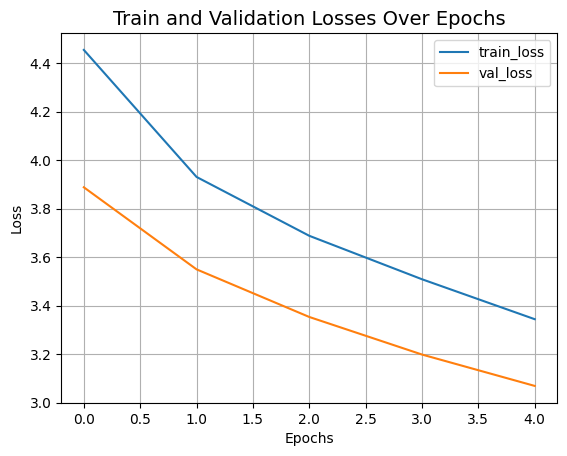

In [16]:
plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Train and Validation Losses Over Epochs", fontsize=14)
plt.legend()
plt.grid()
plt.show()

### Evaluating the trained ViT transformer

In [17]:
loss, accuracy, top_5_accuracy = vit_classifier.evaluate(x_test, y_test)
print(f"Test loss: {round(loss, 2)}")
print(f"Test accuracy: {round(accuracy * 100, 2)}%")
print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

313/313 [==============================] - 39s 126ms/step - loss: 3.0218 - accuracy: 0.2555 - top-5-accuracy: 0.5393
Test loss: 3.02
Test accuracy: 25.55%
Test top 5 accuracy: 53.93%


# Shifted Patch Tokenization

In a ViT pipeline, the input images are divided into patches that are then linearly projected into tokens. Shifted patch tokenization (STP) is introduced to combat the low receptive field of ViTs. The steps for Shifted Patch Tokenization are as follows:
*   Start with an image.
*   Shift the image in diagonal directions.
*   Concat the diagonally shifted images with the original image.
*   Extract patches of the concatenated images.
*   Flatten the spatial dimension of all patches.
*   Layer normalize the flattened patches and then project it.

More details about the implementation can be read from the paper [Vision Transformer for Small-Size Datasets](https://arxiv.org/abs/2112.13492v1)

---
*   Implement a shiftedpatchtokenizer class
*   The class should implement the __init__() and call() functions
*   Implement left-up, right-up, left-down and right-down shift operations


In [ ]:
# solution



*   Visualize the patches for a random image

In [ ]:
# solution



## Build the ViT model

*   Create the ViT classifier by replacing the Patch Layer with the Shifted Patch Layer

In [ ]:
# solution



*   Compile and train the classifier

In [ ]:
# solution



*   Create the history plot for the new ViT model
*   Evaluate the model using the test set

In [ ]:
# solution



*   Compute confusion matrix and classification summary of both the models
*   Compare both the models with respect to the computed metrics

In [ ]:
# solution



**Solution**

*(Double-click or enter to edit)*

...

*   Compare DeiT with ViT. 
*   What are the differences in both the architectures.
*   What is one limitation of ViT that is overcome with a DeiT?

**Solution**

*(Double-click or enter to edit)*

...

*   What is a SWIN Transformer?
*   How is it different from DeiT and ViT?

**Solution**

*(Double-click or enter to edit)*

...

*   What is distillation?
*   Explain the distillation used in DeiT
*   What is its significance? Why do we need distillation?

**Solution**

*(Double-click or enter to edit)*

...

*   Which is better as a teacher model? A transformer based teacher of a CNN based teacher?

**Solution**

*(Double-click or enter to edit)*

...


---

## **End of lab10: Vision Transformers**